In [2]:
import pandas as pd
from datasets import load_dataset
import os

# ==========================================
# STEP 1: LOAD & INSPECT
# ==========================================
print("=== Loading Dataset... ===")

# Dataset download/load
ds = load_dataset("zefang-liu/phishing-email-dataset")
df = pd.DataFrame(ds['train'])

print(f"\nOriginal Columns found: {df.columns.tolist()}")

# ==========================================
# STEP 2: FIX COLUMNS & CHECK LABELS
# ==========================================
# Columns rename kar rahe hain taake code standard ho jaye
df = df.rename(columns={'Email Text': 'text', 'Email Type': 'label'})

print("\n--- Raw Label Distribution ---")
print(df['label'].value_counts())

# Check karte hain ke labels kis format mein hain (Phishing Email vs Safe Email)
print("\n--- Sample Data (First 3 rows) ---")
print(df[['label', 'text']].head(3))

# ==========================================
# STEP 3: BALANCE DATA (Max Possible)
# ==========================================
# Kyunki total ~18k hain, hum check karte hain max kitna balance ho sakta hai
counts = df['label'].value_counts()
min_count = counts.min() 

print(f"\nSabse kam wali class ke paas {min_count} emails hain.")
print(f"Isliye hum dono classes se {min_count} emails uthayenge taake data balance ho.")

# Data Balance Logic
df_group1 = df[df['label'] == counts.index[0]].sample(min_count, random_state=42)
df_group2 = df[df['label'] == counts.index[1]].sample(min_count, random_state=42)

df_balanced = pd.concat([df_group1, df_group2])
# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n" + "="*30)
print("FINAL READY DATASET")
print("="*30)
print(f"Total Emails: {len(df_balanced)}")
print(df_balanced['label'].value_counts())
print("="*30)

# Data save kar lete hain taake agle step mein use ho
df_balanced.to_csv("cleaned_balanced_dataset.csv", index=False)
print("\nFile 'cleaned_balanced_dataset.csv' saved successfully.")

=== Loading Dataset... ===


README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Phishing_Email.csv:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18650 [00:00<?, ? examples/s]


Original Columns found: ['Unnamed: 0', 'Email Text', 'Email Type']

--- Raw Label Distribution ---
label
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

--- Sample Data (First 3 rows) ---
        label                                               text
0  Safe Email  re : 6 . 1100 , disc : uniformitarianism , re ...
1  Safe Email  the other side of * galicismos * * galicismo *...
2  Safe Email  re : equistar deal tickets are you still avail...

Sabse kam wali class ke paas 7328 emails hain.
Isliye hum dono classes se 7328 emails uthayenge taake data balance ho.

FINAL READY DATASET
Total Emails: 14656
label
Phishing Email    7328
Safe Email        7328
Name: count, dtype: int64

File 'cleaned_balanced_dataset.csv' saved successfully.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

=== STEP 1: Loading Balanced Dataset ===
Dataset Loaded Successfully. Total Rows: 14656

=== STEP 2: Splitting Data (80% Train / 20% Test) ===
Total Data for Part 2 (Fine-Tuning): 11724
Total Data for Part 1 (Zero-Shot Test): 2932
Files 'final_train_set.csv' and 'final_test_set.csv' saved.

=== STEP 3: Running Zero-Shot Classification ===
Processing 2932 emails... (This will take time)
Using Device: GPU


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 2932/2932 [03:54<00:00, 12.48it/s]



=== STEP 4: Final Results ===

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.53      0.84      0.65      1466
    Phishing       0.61      0.26      0.36      1466

    accuracy                           0.55      2932
   macro avg       0.57      0.55      0.51      2932
weighted avg       0.57      0.55      0.51      2932

Accuracy Score: 0.5481


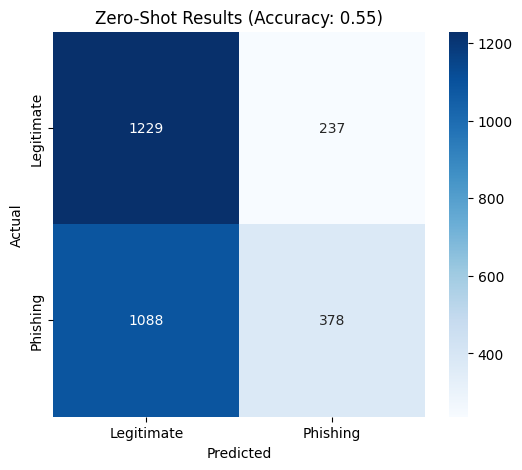

In [3]:
import pandas as pd
import torch
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# STEP 1: LOAD BALANCED DATA
# ==========================================
print("=== STEP 1: Loading Balanced Dataset ===")

# Pichle code se bani hui file load kar rahe hain
try:
    df = pd.read_csv("cleaned_balanced_dataset.csv")
    print(f"Dataset Loaded Successfully. Total Rows: {len(df)}")
except FileNotFoundError:
    print("Error: 'cleaned_balanced_dataset.csv' nahi mili. Pichla code run karein.")
    exit()

# Labels ko simple bana rahe hain Model ke liye
# "Phishing Email" -> "Phishing"
# "Safe Email" -> "Legitimate"
label_map = {'Phishing Email': 'Phishing', 'Safe Email': 'Legitimate'}
df['label_clean'] = df['label'].map(label_map)

# ==========================================
# STEP 2: SPLIT DATA (Train vs Test)
# ==========================================
print("\n=== STEP 2: Splitting Data (80% Train / 20% Test) ===")

# Stratified Split (Taake dono me Phishing/Safe barabar hon)
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label_clean']
)

print(f"Total Data for Part 2 (Fine-Tuning): {len(train_df)}")
print(f"Total Data for Part 1 (Zero-Shot Test): {len(test_df)}")

# Save Train Data for the next assignment part
train_df.to_csv("final_train_set.csv", index=False)
test_df.to_csv("final_test_set.csv", index=False)
print("Files 'final_train_set.csv' and 'final_test_set.csv' saved.")

# ==========================================
# STEP 3: RUN ZERO-SHOT (On Test Set)
# ==========================================
print("\n=== STEP 3: Running Zero-Shot Classification ===")
print(f"Processing {len(test_df)} emails... (This will take time)")

# GPU Check
device = 0 if torch.cuda.is_available() else -1
print(f"Using Device: {'GPU' if device == 0 else 'CPU'}")

# Load Model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)
candidate_labels = ["Phishing", "Legitimate"]

predictions = []
true_labels = test_df['label_clean'].tolist()
texts = test_df['text'].tolist()

# Progress Bar ke sath loop
for i in tqdm(range(len(texts))):
    text = str(texts[i])
    # Truncate text to 1024 chars to avoid errors
    truncated_text = text[:1024]
    
    try:
        result = classifier(truncated_text, candidate_labels)
        predictions.append(result['labels'][0])
    except Exception as e:
        predictions.append("Error")

# ==========================================
# STEP 4: EVALUATION
# ==========================================
print("\n=== STEP 4: Final Results ===")

# Error handling (just in case)
final_preds = []
final_true = []

for p, t in zip(predictions, true_labels):
    if p != "Error":
        final_preds.append(p)
        final_true.append(t)

# Print Metrics
print("\nClassification Report:")
print(classification_report(final_true, final_preds, target_names=["Legitimate", "Phishing"]))

acc = accuracy_score(final_true, final_preds)
print(f"Accuracy Score: {acc:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(final_true, final_preds, labels=["Legitimate", "Phishing"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Legitimate", "Phishing"], yticklabels=["Legitimate", "Phishing"])
plt.title(f'Zero-Shot Results (Accuracy: {acc:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [4]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# STEP 1: LOAD & CLEAN DATA (FIXED)
# ==========================================
print("=== STEP 1: Loading Data from Part 1 ===")

try:
    train_df = pd.read_csv("final_train_set.csv")
    test_df = pd.read_csv("final_test_set.csv")
except FileNotFoundError:
    print("Error: Files nahi milin. Please Part 1 wala code pehle run karein.")
    exit()

# --- CRITICAL FIX START ---
# 1. Drop rows jahan text gayab hai
train_df = train_df.dropna(subset=['text', 'label_clean'])
test_df = test_df.dropna(subset=['text', 'label_clean'])

# 2. Force convert everything to string (Ye error rokega)
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)
# --- CRITICAL FIX END ---

print(f"Cleaned Training Data: {len(train_df)} emails")
print(f"Cleaned Testing Data: {len(test_df)} emails")

# Labels Mapping
label_map = {'Legitimate': 0, 'Phishing': 1}
train_df['label'] = train_df['label_clean'].map(label_map)
test_df['label'] = test_df['label_clean'].map(label_map)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# ==========================================
# STEP 2: TOKENIZATION
# ==========================================
print("\n=== STEP 2: Tokenization ===")

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

print("Tokenizing data... (Processing text into numbers)")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# ==========================================
# STEP 3: SETUP MODEL & TRAINER
# ==========================================
print("\n=== STEP 3: Setting up Model ===")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# UPDATED: 'evaluation_strategy' changed to 'eval_strategy' for newer transformers versions
training_args = TrainingArguments(
    output_dir="./phishing_results_fixed",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",       # Fixed: Renamed from evaluation_strategy
    save_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# ==========================================
# STEP 4: TRAIN
# ==========================================
print("\n=== STEP 4: Starting Training ===")
trainer.train()

# ==========================================
# STEP 5: FINAL EVALUATION & REPORT
# ==========================================
print("\n=== STEP 5: Final Evaluation ===")

predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = test_df['label'].tolist()
target_names = ["Legitimate", "Phishing"]

print(classification_report(true_labels, preds, target_names=target_names))

# Comparison Report
p1_acc = 0.5481 # From your Part 1 Result
p2_acc = accuracy_score(true_labels, preds)
p2_metrics = precision_recall_fscore_support(true_labels, preds, average='binary')

print("\n" + "="*40)
print("FINAL ASSIGNMENT COMPARISON REPORT")
print("="*40)
print(f"{'Metric':<15} | {'Zero-Shot (Part 1)':<20} | {'Fine-Tuned (Part 2)':<20}")
print("-" * 60)
print(f"{'Accuracy':<15} | {p1_acc:.4f}{' '*14} | {p2_acc:.4f}")
print(f"{'Precision (P)':<15} | 0.6100{' '*14} | {p2_metrics[0]:.4f}")
print(f"{'Recall (P)':<15} | 0.2600{' '*14} | {p2_metrics[1]:.4f}")
print(f"{'F1-Score (P)':<15} | 0.3600{' '*14} | {p2_metrics[2]:.4f}")
print("-" * 60)

=== STEP 1: Loading Data from Part 1 ===
Cleaned Training Data: 11712 emails
Cleaned Testing Data: 2928 emails

=== STEP 2: Tokenization ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing data... (Processing text into numbers)


Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/2928 [00:00<?, ? examples/s]


=== STEP 3: Setting up Model ===


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== STEP 4: Starting Training ===


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.152000,0.118785,0.968921,0.969555,0.948919,0.991108
2,0.062400,0.095274,0.976093,0.976335,0.965241,0.987688



=== STEP 5: Final Evaluation ===


              precision    recall  f1-score   support

  Legitimate       0.99      0.96      0.98      1466
    Phishing       0.97      0.99      0.98      1462

    accuracy                           0.98      2928
   macro avg       0.98      0.98      0.98      2928
weighted avg       0.98      0.98      0.98      2928


FINAL ASSIGNMENT COMPARISON REPORT
Metric          | Zero-Shot (Part 1)   | Fine-Tuned (Part 2) 
------------------------------------------------------------
Accuracy        | 0.5481               | 0.9761
Precision (P)   | 0.6100               | 0.9652
Recall (P)      | 0.2600               | 0.9877
F1-Score (P)    | 0.3600               | 0.9763
------------------------------------------------------------


In [5]:
import shutil
import os

# Define the folder you want to download and the output filename
folder_path = './phishing_results_fixed'
output_filename = 'phishing_model_finetuned'

# Create a ZIP file
print("Zipping the model folder... Please wait.")
shutil.make_archive(output_filename, 'zip', folder_path)

print(f"Success! '{output_filename}.zip' has been created.")
print("Go to the 'Output' section on the right side of Kaggle to download it.")

Zipping the model folder... Please wait.
Success! 'phishing_model_finetuned.zip' has been created.
Go to the 'Output' section on the right side of Kaggle to download it.
